100%|██████████| 11/11 [00:00<00:00, 79273.79it/s]


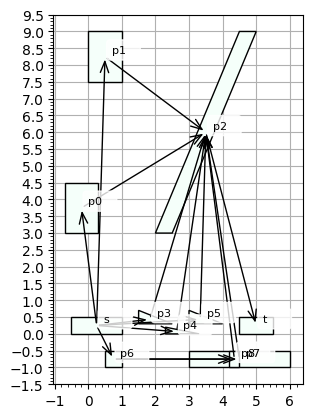

In [1]:
from large_gcs.geometry.polyhedron import Polyhedron
import numpy as np

from large_gcs.graph.cost_constraint_factory import (
    create_2d_x_equality_edge_constraint,
    create_2d_y_equality_edge_constraint,
    create_l1norm_edge_cost,
)
from large_gcs.graph.graph import DefaultGraphCostsConstraints, Edge, Graph


def create_polyhedral_hor_vert_b_graph() -> Graph:
    dim = 2
    # Convex sets
    box_vert = np.array([[0, 0], [1, 0], [1, 1.5], [0, 1.5]], dtype=np.float64)
    sets = (
        # source
        Polyhedron.from_vertices([[-0.5, 0], [1, 0], [1, 0.5], [-0.5, 0.5]]),
        # target
        Polyhedron.from_vertices([[4.5, 0], [5.5, 0], [5.5, 0.5], [4.5, 0.5]]),
        # intermediate sets
        Polyhedron.from_vertices(box_vert + np.array([-0.7, 3])),
        Polyhedron.from_vertices(box_vert + np.array([0, 7.5])),
        # Diagonal set
        Polyhedron.from_vertices([[2, 3], [2.5, 3], [5, 9], [4.5, 9]]),
        # Cluster of 3
        Polyhedron.from_vertices([[1.5, 0.3], [2.5, 0.3], [1.5, 0.7]]),
        Polyhedron.from_vertices([[2.3, 0], [3.3, 0], [2.3, 0.2]]),
        Polyhedron.from_vertices([[3, 0.3], [4, 0.3], [3, 0.7]]),
        # Bottom row
        Polyhedron.from_vertices([[0.5, -1], [1, -1], [1, -0.5], [0.5, -0.5]]),
        Polyhedron.from_vertices([[3, -1], [6, -1], [6, -0.5], [3, -0.5]]),
        Polyhedron.from_vertices([[4.2, -1], [4.5, -1], [4.5, -0.5], [4.2, -0.5]]),
    )

    # Vertex names
    vertex_names = ["s", "t"]
    vertex_names += [f"p{i}" for i in range(len(sets) - 2)]

    # Edge costs
    # edge_cost = create_l2norm_squared_edge_cost(dim)
    edge_cost = create_l1norm_edge_cost(dim)
    default_costs_constraints = DefaultGraphCostsConstraints(edge_costs=[edge_cost])
    # Add convex sets to graph
    G = Graph(default_costs_constraints)
    G.add_vertices_from_sets(sets, names=vertex_names)
    G.set_source("s")
    G.set_target("t")

    # Edges
    vert_edges = {
        "s": ("p0", "p1", "p6"),
        "p2": ("t",),
        "p3": ("p2",),
        "p4": ("p2",),
        "p5": ("p2",),
        "p7": ("p2",),
        "p8": ("p2",),
    }
    hor_edges = {
        "s": (
            "p3",
            "p4",
            "p5",
        ),
        "p0": ("p2",),
        "p1": ("p2",),
        "p6": (
            "p7",
            "p8",
        ),
    }

    def add_edges(edges, constraints):
        for u, vs in edges.items():
            for v in vs:
                # print(f"Adding edge {u} -> {v}")
                G.add_edge(Edge(u, v, constraints=constraints))

    vert_constraint = [create_2d_x_equality_edge_constraint()]
    hor_constraint = [create_2d_y_equality_edge_constraint()]
    add_edges(vert_edges, vert_constraint)
    add_edges(hor_edges, hor_constraint)
    return G


G = create_polyhedral_hor_vert_b_graph()
G.plot_sets()
G.plot_edges()
G.plot_set_labels()
import matplotlib.pyplot as plt

# Setting major and minor ticks
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(plt.MultipleLocator(1))  # Major ticks at every 1
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.2))  # Minor ticks at every 0.2
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
plt.grid()

In [2]:
def plot_sol(sol):
    G.plot_sets()
    G.plot_path(sol.ambient_path)

In [3]:
# sol = G.solve_shortest_path()
# plot_sol(sol)

In [4]:
from large_gcs.algorithms.gcs_astar_reachability import GcsAstarReachability
from large_gcs.algorithms.search_algorithm import AlgVisParams
from large_gcs.cost_estimators.shortcut_edge_ce import ShortcutEdgeCE
from large_gcs.domination_checkers.reaches_cheaper_sampling import (
    ReachesCheaperSampling,
)
from large_gcs.graph.cost_constraint_factory import l1_norm_shortcut_edge_cost_factory

# cost_estimator = ShortcutEdgeCE(graph=G,
#                                 shortcut_edge_cost_factory=l1_norm_shortcut_edge_cost_factory,
#                                 )
# alg_vis_params = AlgVisParams()
# domination_checker = ReachesCheaperSampling(graph=G, num_samples_per_vertex=10)
# alg = GcsAstarReachability(graph=G,
#                            cost_estimator=cost_estimator,
#                            domination_checker=domination_checker,
#                            vis_params=alg_vis_params,
#                            )
# sol = alg.run()
# plot_sol(sol)

In [5]:
# from large_gcs.domination_checkers.reaches_new_sampling import ReachesNewSampling


# cost_estimator = ShortcutEdgeCE(graph=G,
#                                 shortcut_edge_cost_factory=l1_norm_shortcut_edge_cost_factory,
#                                 )
# alg_vis_params = AlgVisParams()
# domination_checker = ReachesNewSampling(graph=G, num_samples_per_vertex=10)
# alg = GcsAstarReachability(graph=G,
#                            cost_estimator=cost_estimator,
#                            domination_checker=domination_checker,
#                            vis_params=alg_vis_params,
#                            )
# sol = alg.run()
# plot_sol(sol)

In [6]:
from large_gcs.domination_checkers.ah_containment_domination_checker import (
    AHContainmentDominationChecker,
)
import numpy as np

A_x = np.array([[1, 1], [-1, 1], [0, -1]])
b_x = np.array([1, 1, 0])
A_y = np.array([[1, 1], [-1, 1], [0, -1]])
b_y = np.array([1, 1, 0])
domination_checker = AHContainmentDominationChecker(graph=G)

domination_checker.is_contained_in(A_x, b_x, A_y, b_y, 1)

True

In [7]:
from large_gcs.algorithms.search_algorithm import SearchNode
from pydrake.all import HPolyhedron

candidate_node = SearchNode.from_vertex_path(["s", "p1", "p2"])
alt_node = SearchNode.from_vertex_path(["s", "p6", "p7", "p2"])

prog_x = domination_checker.get_path_constraint_mathematical_program(candidate_node)
X = HPolyhedron(prog_x)
prog_y = domination_checker.get_path_constraint_mathematical_program(alt_node)
Y = HPolyhedron(prog_y)

domination_checker.is_contained_in(X.A(), X.b(), Y.A(), Y.b(), 2)

True

In [8]:
domination_checker.is_contained_in(Y.A(), Y.b(), X.A(), X.b(), 2)

False

In [9]:
from pydrake.solvers import MathematicalProgram
from pydrake.all import Binding, Cost

In [10]:
# prog = MathematicalProgram()
# x = prog.NewContinuousVariables(2, "x")
# prog.AddL1NormCost(x, 1)

In [11]:
G.edge_keys

["('s', 'p0')",
 "('s', 'p1')",
 "('s', 'p6')",
 "('p2', 't')",
 "('p3', 'p2')",
 "('p4', 'p2')",
 "('p5', 'p2')",
 "('p7', 'p2')",
 "('p8', 'p2')",
 "('s', 'p3')",
 "('s', 'p4')",
 "('s', 'p5')",
 "('p0', 'p2')",
 "('p1', 'p2')",
 "('p6', 'p7')",
 "('p6', 'p8')"]

In [12]:
e: Edge = G.edges["('s', 'p0')"]
cost = e.costs[0]
x = np.concatenate([e.gcs_edge.xu(), e.gcs_edge.xv()])
binding = Binding[Cost](cost, x)
binding.variables()
# e.gcs_edge.AddCost(binding)
# cost.variables()

array([Variable('s(0)', Continuous), Variable('s(1)', Continuous),
       Variable('p0(0)', Continuous), Variable('p0(1)', Continuous)],
      dtype=object)

In [13]:
x

array([Variable('s(0)', Continuous), Variable('s(1)', Continuous),
       Variable('p0(0)', Continuous), Variable('p0(1)', Continuous)],
      dtype=object)

In [14]:
candidate_node = SearchNode.from_vertex_path(["s", "p1"])
prog_x = domination_checker.get_path_mathematical_program(candidate_node)
# X = HPolyhedron(prog_x)

In [15]:
prog_x.decision_variables()

array([Variable('s_vars(0)', Continuous),
       Variable('s_vars(1)', Continuous),
       Variable('p1_vars(0)', Continuous),
       Variable('p1_vars(1)', Continuous),
       Variable('('s', 'p1')_l1norm_cost(0)', Continuous),
       Variable('('s', 'p1')_l1norm_cost(1)', Continuous)], dtype=object)

In [16]:
print(prog_x.GetAllCosts()[0])

LinearCost (('s', 'p1')_l1norm_cost(0) + ('s', 'p1')_l1norm_cost(1))


In [17]:
def find_index(list, el):
    for i in range(len(list)):
        if list[i].get_id() == el.get_id():
            return i
    return -1

In [18]:
vars = list(prog_x.decision_variables())
cs = prog_x.GetAllCosts()
c_coeff_vec = np.zeros(len(vars))
for c in cs:
    c_vars = c.variables()
    c_coeff = c.evaluator().a()
    for i_c_var, c_var in enumerate(c_vars):
        c_var_ind = find_index(vars, c_var)

        c_coeff_vec[c_var_ind] += c_coeff[i_c_var]
X = HPolyhedron(prog_x)
col = np.zeros(X.A().shape[0] + 1)
col[-1] = -1
A_x = np.hstack((np.vstack([X.A(), c_coeff_vec]), col.reshape(-1, 1)))
b_x = np.hstack([X.b(), 0])
print(X.A())

print(X.b())
print("-----------------")
print(A_x)
print(b_x)

[[ 1.  0. -1.  0.  0.  0.]
 [-1.  0.  1.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.]
 [ 1.  0. -1.  0. -1.  0.]
 [ 0.  1.  0. -1.  0. -1.]
 [-1.  0.  1.  0. -1.  0.]
 [ 0. -1.  0.  1.  0. -1.]]
[ 0.00000000e+00 -0.00000000e+00  1.71272392e-15  1.00000000e+00
  5.00000000e-01  5.00000000e-01 -7.50000000e+00  1.00000000e+00
  9.00000000e+00  1.29674049e-14  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
-----------------
[[ 1.  0. -1.  0.  0.  0.  0.]
 [-1.  0.  1.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 1.  0. -1.  0. -1.  0.  0.]
 [ 0.  1.  0. -1.  0. -1.  0.]
 [

In [19]:
c_coeff_vec

array([0., 0., 0., 0., 1., 1.])

In [20]:
from large_gcs.algorithms.search_algorithm import SearchNode
from pydrake.all import HPolyhedron

candidate_node = SearchNode.from_vertex_path(["s", "p1", "p2"])
alt_node = SearchNode.from_vertex_path(["s", "p6", "p7", "p2"])
other_node = SearchNode.from_vertex_path(["s", "p6", "p8", "p2"])

A_x, b_x = domination_checker.get_epigraph_matrices(candidate_node)
A_y, b_y = domination_checker.get_epigraph_matrices(alt_node)
A_z, b_z = domination_checker.get_epigraph_matrices(other_node)


not domination_checker.is_contained_in(A_x, b_x, A_y, b_y, 3)

True

In [21]:
not domination_checker.is_contained_in(A_y, b_y, A_x, b_x, 3)

True

In [22]:
not domination_checker.is_contained_in(A_z, b_z, A_x, b_x, 3)

True